# Import

In [11]:
from pathlib import Path

import polars as pl

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

from sklearn.utils import resample
import optuna
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2


import sys
sys.path.append('../src')
from utils import set_seed, visualize_augmentations_positive, print_trainable_parameters
from models import setup_model
from training import fetch_scheduler, train_one_epoch, valid_one_epoch, run_training, get_nth_test_step, criterion, combined_criterion
from models import ISICModel, ISICModelSegL, ISICModelEdgnet, ISICModelEdgnetSegL, ISICModelEdgnet, setup_model
from datasets import ISICDatasetSamplerW, ISICDatasetSampler, ISICDatasetSimple, ISICDatasetSamplerMulticlass, prepare_loaders
from augmentations import get_augmentations
import warnings
warnings.filterwarnings("ignore")

# Config

In [2]:
# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

original_data_path = "../data/original"
original_root = Path('../data/original')

data_artifacts = "../data/artifacts"
os.makedirs(data_artifacts, exist_ok=True)


# Set the HDF5 file path
TRAIN_HDF5_FILE_PATH = original_root / 'train-image.hdf5'

train_path = original_root / 'train-metadata.csv'
df_train = pd.read_csv(train_path)
df_train["path"] = '../data/original/train-image/image/' + df_train['isic_id'] + ".jpg"
original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti
Number of GPUs: 1


C:\Users\mdzh1\AppData\Local\Temp\ipykernel_8164\4143386242.py:20: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


Number of positive cases: 393
Number of negative cases: 400666
Ratio of negative to positive cases: 1019.51:1


In [3]:
# MODEL_NAME = "EVA" # "EDGENEXT"
MODEL_NAME = "EVA" 

CONFIG = {
    "seed": 42 if MODEL_NAME == 'EVA' else 1997,
    "epochs": 500,
    "img_size": 336 if MODEL_NAME == 'EVA' else 256,
    "train_batch_size": 32,
    "valid_batch_size": 128,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 2000,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "group_col": 'patient_id',
    "device": device
}

model_name = "eva02_small_patch14_336.mim_in22k_ft_in1k" if MODEL_NAME == 'EVA' else "edgenext_base.in21k_ft_in1k"
checkpoint_path = None


if MODEL_NAME == 'EVA':
    ISICModelPrep = ISICModel
else:
    ISICModelPrep = ISICModelEdgnet


data_transforms = get_augmentations(CONFIG)

c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
d:\Work\UNT\UNT Coursework\Spring 25\CSCE 5218\Project\isic-2024-challenge\notebooks\../src\augmentations.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
d:\Work\UNT\UNT Coursework\Spring 25\CSCE 5218\Project\isic-2024-challenge\notebooks\../src\augmentations.py:31: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


# EVA02 Synth Validation

In [5]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from tqdm import tqdm

def custom_metric_raw(y_hat, y_true):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Load the model
model = setup_model(
    model_name="eva02_small_patch14_336.mim_in22k_ft_in1k",
    drop_path_rate=0.0,
    drop_rate=0.0,
    model_maker=ISICModel  # already defined in your script
)
checkpoint_path = "../weights/oof_eva_base__synth/model__0"
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
model.eval().to(device)

NUM_FOLDS = 3
models_folder = "../weights/oof_eva_base__synth/"
# === Load Metadata ===
df = pd.read_csv("../data/original/train-metadata.csv")
df = df.dropna(subset=["target", CONFIG["group_col"]])  # safety

# === Fold Split ===
tsp = StratifiedGroupKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=CONFIG["seed"])
folds = list(tsp.split(df, y=df["target"], groups=df[CONFIG["group_col"]]))

auroc_scores = []
pauc_scores = []
weight_path = os.path.join(models_folder, f"model__0")

for fold_n, (train_idx, val_idx) in enumerate(folds):
    print(f"\n===== Fold {fold_n} =====")

    df_valid = df.iloc[val_idx].reset_index(drop=True)
    df_valid['path'] = df_valid['isic_id'].apply(lambda x: f"../data/original/train-image/image/{x}.jpg")
    valid_dataset = ISICDatasetSimple(df_valid, transforms=data_transforms["valid"])

    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=CONFIG['valid_batch_size'], 
        shuffle=False,
        num_workers=4, 
        pin_memory=True
    )
    
    preds = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Predicting Fold {fold_n}"):
            inputs = batch["image"].to(CONFIG["device"])
            labels = batch["target"].cpu().numpy()
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze().detach().cpu().numpy()
            preds.extend(probs if probs.ndim == 1 else probs.tolist())
            targets.extend(labels)

    preds = np.array(preds)
    targets = np.array(targets)

    auroc = roc_auc_score(targets, preds)
    pauc = custom_metric_raw(preds, targets)

    print(f"Fold {fold_n} AUROC: {auroc:.5f}")
    print(f"Fold {fold_n} pAUC : {pauc:.5f}")

    auroc_scores.append(auroc)
    pauc_scores.append(pauc)

print("\n==== Cross Validation Summary ====")
for i in range(NUM_FOLDS):
    print(f"Fold {i}: AUROC = {auroc_scores[i]:.5f}, pAUC = {pauc_scores[i]:.5f}")

print(f"\nMean AUROC: {np.mean(auroc_scores):.5f} ± {np.std(auroc_scores):.5f}")
print(f"Mean pAUC : {np.mean(pauc_scores):.5f} ± {np.std(pauc_scores):.5f}")

C:\Users\mdzh1\AppData\Local\Temp\ipykernel_8164\1465221594.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati


===== Fold 0 =====


Predicting Fold 0: 100%|██████████| 1030/1030 [06:37<00:00,  2.59it/s]


Fold 0 AUROC: 0.96130
Fold 0 pAUC : 0.17342

===== Fold 1 =====


Predicting Fold 1: 100%|██████████| 1076/1076 [06:52<00:00,  2.61it/s]


Fold 1 AUROC: 0.93261
Fold 1 pAUC : 0.15007

===== Fold 2 =====


Predicting Fold 2: 100%|██████████| 1028/1028 [06:51<00:00,  2.50it/s]

Fold 2 AUROC: 0.95316
Fold 2 pAUC : 0.16648

==== Cross Validation Summary ====
Fold 0: AUROC = 0.96130, pAUC = 0.17342
Fold 1: AUROC = 0.93261, pAUC = 0.15007
Fold 2: AUROC = 0.95316, pAUC = 0.16648

Mean AUROC: 0.94902 ± 0.01207
Mean pAUC : 0.16332 ± 0.00979


# EVA02 and EdgeNeXt Ensemble 

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# === Custom pAUC Function ===
def custom_metric_raw(y_hat, y_true):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])

    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return partial_auc

# === Load OOF Forecasts ===
df1 = pd.read_parquet('../data/artifacts/oof_forecasts_edgenext_base_synth_hr.parquet')
df2 = pd.read_parquet('../data/artifacts/oof_forecasts_eva.parquet')

# === Merge on 'isic_id'
merged = pd.merge(df1[['isic_id', 'tmp_predictions_all', 'tmp_targets_all']],
                  df2[['isic_id', 'tmp_predictions_all']],
                  on='isic_id',
                  suffixes=('_m1', '_m2'))

# === Ensemble: Average Predictions
merged['ensemble_pred'] = (merged['tmp_predictions_all_m1'] + merged['tmp_predictions_all_m2']) / 2

# === Final pAUC and AUROC
y_true = merged['tmp_targets_all'].values
y_pred = merged['ensemble_pred'].values

auroc = roc_auc_score(y_true, y_pred)
pauc = custom_metric_raw(y_pred, y_true)

print(f"\nEnsemble AUROC: {auroc:.5f}")
print(f"Ensemble pAUC : {pauc:.5f}")


Ensemble AUROC: 0.94237
Ensemble pAUC : 0.15812


# Standalone EVA02 and EdgeNeXt Analysis

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score


def custom_metric_raw(y_hat, y_true):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])

    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return partial_auc


# === Select Model ===
model_flag = "edgenext"  # options: "edgenext" or "eva"

file_path = f"../data/artifacts/oof_forecasts_{model_flag}_base.parquet"

print(f"Loading OOF data from: {file_path}")

df = pd.read_parquet(file_path)

# Check data
print(f"Total rows = {len(df)}, Unique isic_id = {df['isic_id'].nunique()}")

# Group by isic_id and average predictions
ensemble_df = df.groupby('isic_id').agg({
    'tmp_predictions_all': 'mean',
    'tmp_targets_all': 'first'  # same target across folds
}).reset_index()

y_true = ensemble_df['tmp_targets_all'].values
y_pred = ensemble_df['tmp_predictions_all'].values

auroc = roc_auc_score(y_true, y_pred)
pauc = custom_metric_raw(y_pred, y_true)

print(f"\nModel: {model_flag}")
print(f"Ensemble AUROC: {auroc:.5f}")
print(f"Ensemble pAUC : {pauc:.5f}")

# === Select Model ===
model_flag = "eva"  # options: "edgenext" or "eva"

file_path = f"../data/artifacts/oof_forecasts_{model_flag}.parquet"

print(f"Loading OOF data from: {file_path}")

df = pd.read_parquet(file_path)

# Check data
print(f"Total rows = {len(df)}, Unique isic_id = {df['isic_id'].nunique()}")

# Group by isic_id and average predictions
ensemble_df = df.groupby('isic_id').agg({
    'tmp_predictions_all': 'mean',
    'tmp_targets_all': 'first'  # same target across folds
}).reset_index()

y_true = ensemble_df['tmp_targets_all'].values
y_pred = ensemble_df['tmp_predictions_all'].values

auroc = roc_auc_score(y_true, y_pred)
pauc = custom_metric_raw(y_pred, y_true)

print(f"\nModel: {model_flag}")
print(f"Ensemble AUROC: {auroc:.5f}")
print(f"Ensemble pAUC : {pauc:.5f}")

# === Select Model ===
model_flag = "edgenext"  # options: "edgenext" or "eva"

file_path = f"../data/artifacts/oof_forecasts_{model_flag}_base_synth_hr.parquet"

print(f"Loading OOF data from: {file_path}")

df = pd.read_parquet(file_path)

# Check data
print(f"Total rows = {len(df)}, Unique isic_id = {df['isic_id'].nunique()}")

# Group by isic_id and average predictions
ensemble_df = df.groupby('isic_id').agg({
    'tmp_predictions_all': 'mean',
    'tmp_targets_all': 'first'  # same target across folds
}).reset_index()

y_true = ensemble_df['tmp_targets_all'].values
y_pred = ensemble_df['tmp_predictions_all'].values

auroc = roc_auc_score(y_true, y_pred)
pauc = custom_metric_raw(y_pred, y_true)

print(f"\nModel: {model_flag}")
print(f"Ensemble AUROC: {auroc:.5f}")
print(f"Ensemble pAUC : {pauc:.5f}")

Loading OOF data from: ../data/artifacts/oof_forecasts_edgenext_base.parquet
Total rows = 401059, Unique isic_id = 401059

Model: edgenext
Ensemble AUROC: 0.91364
Ensemble pAUC : 0.13994
Loading OOF data from: ../data/artifacts/oof_forecasts_eva.parquet
Total rows = 401059, Unique isic_id = 401059

Model: eva
Ensemble AUROC: 0.92911
Ensemble pAUC : 0.15159
Loading OOF data from: ../data/artifacts/oof_forecasts_edgenext_base_synth_hr.parquet
Total rows = 401059, Unique isic_id = 401059

Model: edgenext
Ensemble AUROC: 0.93649
Ensemble pAUC : 0.15564


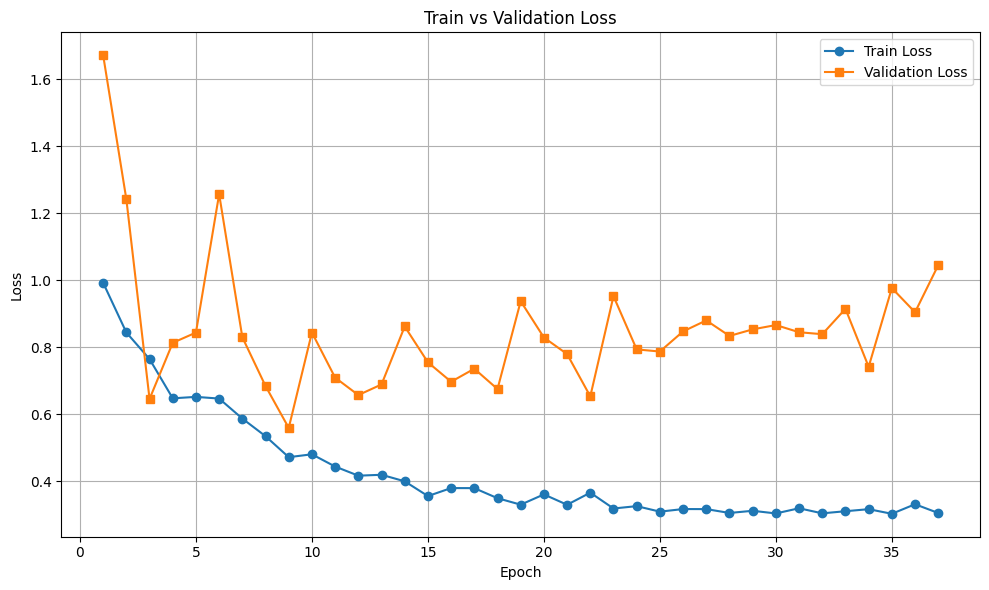

In [21]:
import json
import matplotlib.pyplot as plt

# Load history from JSON
with open('../weights/oof_edgenext_sac_unet/history__0.json', 'r') as f:
    history = json.load(f)

# Extract loss values
train_loss = history['Train Loss']
val_loss = history['Valid Loss']
epochs = list(range(1, len(train_loss) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


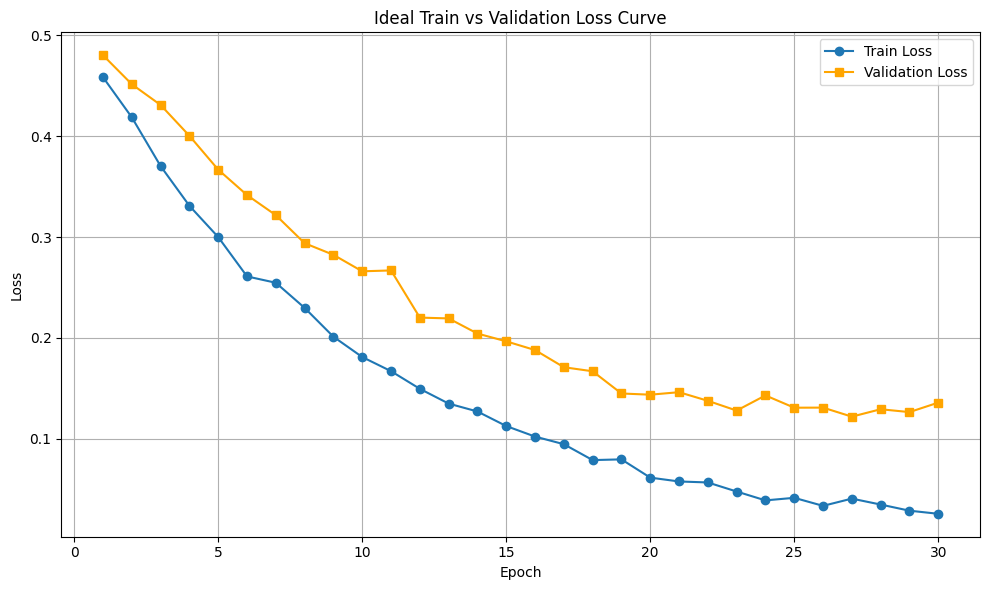

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate dummy epochs
epochs = np.arange(1, 31)

# Generate ideal Train Loss - exponential decay + noise
train_loss = 0.5 * np.exp(-0.1 * epochs) + np.random.normal(0, 0.005, len(epochs))

# Generate ideal Val Loss - decreases first, then flattens or increases slightly
val_loss = 0.5 * np.exp(-0.07 * epochs) + 0.02 + np.random.normal(0, 0.005, len(epochs))

# Introduce slight overfitting after 20th epoch
val_loss[20:] += 0.005 * (epochs[20:] - 20)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ideal Train vs Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
